In [1]:
# pip install tensorflow 

In [2]:
# pip install scikit-learn

In [3]:
# pip install opencv-python

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
csv_train = pd.read_csv('./datasets/skin-cancer-mnist-ham10000/HAM10000_metadata_cleansed_train.csv',sep=',')
csv_test = pd.read_csv('./datasets/skin-cancer-mnist-ham10000/HAM10000_metadata_cleansed_test.csv',sep=',')

In [6]:
dx_cat = {'bkl':0, 'nv':1, 'df':2, 'mel':3, 'vasc':4, 'bcc':5, 'akiec':6}
dx_type_cat = {'histo':0, 'follow_up':.3, 'consensus':.6, 'confocal':.9}
sex_cat = {'male':0, 'female':1, 'unknown':.5}
localization_cat = {'back':0, 'face':.07, 'lower extremity':.14, 'trunk':.21, 'abdomen':.28, 'upper extremity':.35,
                    'foot':.42, 'scalp':.49, 'unknown':.56, 'ear':.63, 'hand':.7, 'chest':.77, 'neck':.84,
                    'genital':.91, 'acral':.98}

csv_train.age = csv_train.age.astype(float)
csv_train.age = csv_train.age/np.max(csv_train.age)

csv_train.dx = csv_train.dx.map(dx_cat).astype(float)
csv_train.dx_type = csv_train.dx_type.map(dx_type_cat).astype(float)
csv_train.sex = csv_train.sex.map(sex_cat).astype(float)
csv_train.localization = csv_train.localization.map(localization_cat).astype(float)

csv_test.age = csv_test.age.astype(float)
csv_test.age = csv_test.age/np.max(csv_test.age)

csv_test.dx = csv_test.dx.map(dx_cat).astype(float)
csv_test.dx_type = csv_test.dx_type.map(dx_type_cat).astype(float)
csv_test.sex = csv_test.sex.map(sex_cat).astype(float)
csv_test.localization = csv_test.localization.map(localization_cat).astype(float)

In [7]:
display(csv_train.head(10))

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000005,ISIC_0025577,6.0,0.0,0.882353,1.0,0.14
1,HAM_0000005,ISIC_0030591,6.0,0.0,0.882353,1.0,0.14
2,HAM_0000005,ISIC_0024579,6.0,0.0,0.882353,1.0,0.14
3,HAM_0000005,ISIC_0029638,6.0,0.0,0.882353,1.0,0.14
4,HAM_0000020,ISIC_0031922,6.0,0.0,0.705882,1.0,0.07
5,HAM_0000193,ISIC_0030877,6.0,0.0,0.705882,1.0,0.07
6,HAM_0000193,ISIC_0027950,6.0,0.0,0.705882,1.0,0.07
7,HAM_0000239,ISIC_0033866,6.0,0.0,0.941176,0.0,0.07
8,HAM_0000239,ISIC_0032854,6.0,0.0,0.941176,0.0,0.07
9,HAM_0000356,ISIC_0026171,6.0,0.0,0.705882,1.0,0.07


In [8]:
#Re-balance data if needed

csv_train = csv_train.append(csv_train.loc[csv_train['dx'] == 2.0])
csv_train = csv_train.append(csv_train.loc[csv_train['dx'] == 2.0])
csv_train = csv_train.append(csv_train.loc[csv_train['dx'] == 4.0])
csv_train = csv_train.append(csv_train.loc[csv_train['dx'] == 4.0])
csv_train = csv_train.append(csv_train.loc[csv_train['dx'] == 6.0])


In [9]:
# Returns a 100% sample randomised

csv_train = csv_train.sample(frac=1)

In [10]:
display(csv_train.head(10))

,lesion_id,image_id,dx,dx_type,age,sex,localization
2834,HAM_0006828,ISIC_0031977,3.0,0.0,1.000000,0.0,0.00
5719,HAM_0003246,ISIC_0029049,1.0,0.0,0.000000,0.0,0.63
1815,HAM_0005663,ISIC_0028735,2.0,0.6,0.352941,0.0,0.14
5144,HAM_0002581,ISIC_0026544,1.0,0.0,0.470588,0.0,0.00
1,HAM_0000005,ISIC_0030591,6.0,0.0,0.882353,1.0,0.14
3213,HAM_0000412,ISIC_0032706,1.0,0.6,0.823529,0.0,0.21
7264,HAM_0005016,ISIC_0027045,1.0,0.0,0.705882,0.0,0.00
535,HAM_0003690,ISIC_0034155,5.0,0.0,0.529412,1.0,0.56
8093,HAM_0006007,ISIC_0031737,1.0,0.3,0.529412,1.0,0.21
3368,HAM_0000589,ISIC_0027103,1.0,0.0,0.176471,1.0,0.84


In [11]:
# Set your X and Y train and test data up in Pandas - Example 

X_train_data = csv_train.drop(['dx_type','lesion_id', 'image_id', 'dx'],axis=1)
Y_train_data = csv_train['dx']

X_test_data = csv_test.drop(['dx_type','lesion_id', 'image_id', 'dx'],axis=1)
Y_test_data = csv_test['dx']


In [12]:
type(X_train_data)

pandas.core.frame.DataFrame

In [13]:
# Define where you are reading images from, here the column of the CSV file
# with the name of the image (randomised and in the same order as above)

X_train_img = csv_train['image_id']

X_test_img = csv_test['image_id']

In [14]:
img_folder = './datasets/skin-cancer-mnist-ham10000/HAM10000_images_s/'

In [15]:
# Re-shape and pre-process train images using OpenCV

X_train = []
for image_get in X_train_img:
    img_train = cv2.imread(img_folder + '{}.jpg'.format(image_get))
    
    img_train = cv2.resize(img_train,(100,75))
    
    # img_train = img_train[0:224,38:262] # What does this do???

    R,G,B = cv2.split(img_train)
    R_new = cv2.equalizeHist(R)
    G_new = cv2.equalizeHist(G)
    B_new = cv2.equalizeHist(B)

    img_train = cv2.merge([R_new,G_new,B_new])
    img_train = cv2.GaussianBlur(img_train,(5,5),0)
    
    X_train.append(img_train)

In [16]:
X_train[0:1]

[array([[[166, 231, 225],
         [176, 236, 230],
         [197, 244, 237],
         ...,
         [238, 232, 215],
         [225, 221, 221],
         [216, 213, 220]],
 
        [[168, 234, 228],
         [177, 237, 232],
         [196, 245, 236],
         ...,
         [237, 232, 219],
         [223, 219, 222],
         [214, 210, 219]],
 
        [[170, 238, 234],
         [178, 241, 236],
         [194, 246, 235],
         ...,
         [234, 232, 227],
         [218, 215, 225],
         [209, 204, 221]],
 
        ...,
 
        [[200, 196, 171],
         [198, 202, 171],
         [194, 213, 172],
         ...,
         [120, 145, 184],
         [119, 144, 183],
         [119, 143, 184]],
 
        [[201, 183, 166],
         [200, 192, 168],
         [198, 210, 173],
         ...,
         [112, 130, 165],
         [109, 127, 163],
         [108, 127, 165]],
 
        [[201, 175, 159],
         [201, 186, 163],
         [200, 208, 171],
         ...,
         [110, 125, 158],
  

In [17]:
# Convert to Numpy array
X_train = np.array(X_train)

In [18]:
X_train[0:1]

array([[[[166, 231, 225],
         [176, 236, 230],
         [197, 244, 237],
         ...,
         [238, 232, 215],
         [225, 221, 221],
         [216, 213, 220]],

        [[168, 234, 228],
         [177, 237, 232],
         [196, 245, 236],
         ...,
         [237, 232, 219],
         [223, 219, 222],
         [214, 210, 219]],

        [[170, 238, 234],
         [178, 241, 236],
         [194, 246, 235],
         ...,
         [234, 232, 227],
         [218, 215, 225],
         [209, 204, 221]],

        ...,

        [[200, 196, 171],
         [198, 202, 171],
         [194, 213, 172],
         ...,
         [120, 145, 184],
         [119, 144, 183],
         [119, 143, 184]],

        [[201, 183, 166],
         [200, 192, 168],
         [198, 210, 173],
         ...,
         [112, 130, 165],
         [109, 127, 163],
         [108, 127, 165]],

        [[201, 175, 159],
         [201, 186, 163],
         [200, 208, 171],
         ...,
         [110, 125, 158],
        

In [19]:
X_test = []
for image_get in X_test_img:
    img_test = cv2.imread(img_folder + '{}.jpg'.format(image_get))
    
    img_test = cv2.resize(img_test,(100,75))
    #img_test = img_test[0:224  ,  38:262]
    
    R,G,B = cv2.split(img_test)
    R_new = cv2.equalizeHist(R)
    G_new = cv2.equalizeHist(G)
    B_new = cv2.equalizeHist(B)
    
    img_test = cv2.merge([R_new,G_new,B_new])
    img_test = cv2.GaussianBlur(img_test,(5,5),0)
  
    X_test.append(img_test)

In [20]:
X_test = np.array(X_test)

In [21]:
# Convert to numpy array data to float32
X_train = X_train.astype(np.float32)

X_test = X_test.astype(np.float32)

In [22]:
X_train[0:1]

array([[[[166., 231., 225.],
         [176., 236., 230.],
         [197., 244., 237.],
         ...,
         [238., 232., 215.],
         [225., 221., 221.],
         [216., 213., 220.]],

        [[168., 234., 228.],
         [177., 237., 232.],
         [196., 245., 236.],
         ...,
         [237., 232., 219.],
         [223., 219., 222.],
         [214., 210., 219.]],

        [[170., 238., 234.],
         [178., 241., 236.],
         [194., 246., 235.],
         ...,
         [234., 232., 227.],
         [218., 215., 225.],
         [209., 204., 221.]],

        ...,

        [[200., 196., 171.],
         [198., 202., 171.],
         [194., 213., 172.],
         ...,
         [120., 145., 184.],
         [119., 144., 183.],
         [119., 143., 184.]],

        [[201., 183., 166.],
         [200., 192., 168.],
         [198., 210., 173.],
         ...,
         [112., 130., 165.],
         [109., 127., 163.],
         [108., 127., 165.]],

        [[201., 175., 159.],
       

In [23]:
# Reduce to float between 0 and 1 (256 per channel)
X_train /=255

X_test /=255

In [24]:
X_train[0:1]

array([[[[0.6509804 , 0.90588236, 0.88235295],
         [0.6901961 , 0.9254902 , 0.9019608 ],
         [0.77254903, 0.95686275, 0.92941177],
         ...,
         [0.93333334, 0.9098039 , 0.84313726],
         [0.88235295, 0.8666667 , 0.8666667 ],
         [0.84705883, 0.8352941 , 0.8627451 ]],

        [[0.65882355, 0.91764706, 0.89411765],
         [0.69411767, 0.92941177, 0.9098039 ],
         [0.76862746, 0.9607843 , 0.9254902 ],
         ...,
         [0.92941177, 0.9098039 , 0.85882354],
         [0.8745098 , 0.85882354, 0.87058824],
         [0.8392157 , 0.8235294 , 0.85882354]],

        [[0.6666667 , 0.93333334, 0.91764706],
         [0.69803923, 0.94509804, 0.9254902 ],
         [0.7607843 , 0.9647059 , 0.92156863],
         ...,
         [0.91764706, 0.9098039 , 0.8901961 ],
         [0.85490197, 0.84313726, 0.88235295],
         [0.81960785, 0.8       , 0.8666667 ]],

        ...,

        [[0.78431374, 0.76862746, 0.67058825],
         [0.7764706 , 0.7921569 , 0.67058825]

In [25]:
print(X_train.shape, X_test.shape)

(9932, 75, 100, 3) (1002, 75, 100, 3)


In [26]:
X_train_image = X_train
X_test_image = X_test

Now to process the text data from the CSV file

In [27]:
X_train_data.head()

,age,sex,localization
2834,1.000000,0.0,0.00
5719,0.000000,0.0,0.63
1815,0.352941,0.0,0.14
5144,0.470588,0.0,0.00
1,0.882353,1.0,0.14


In [28]:
# Convert training text dataframe to numpy values

X_train_data = X_train_data.values

X_test_data = X_test_data.values

In [29]:
type(X_train_data)

numpy.ndarray

In [30]:
X_train_data.shape

(9932, 3)

In [31]:
X_train_data[0:1]

array([[1., 0., 0.]])

In [32]:
# Convert training text dataframe to values for numpy

Y_train_data = Y_train_data.values

Y_test_data = Y_test_data.values

In [33]:
Y_train_data[:5]

array([3., 1., 2., 1., 6.])

In [34]:
Y_train_data = Y_train_data.reshape(-1,1)

Y_test_data = Y_test_data.reshape(-1,1)

In [35]:
Y_train_data[:5]

array([[3.],
       [1.],
       [2.],
       [1.],
       [6.]])

In [36]:
# One hot encode the classifications in the Y data
encoder_train = OneHotEncoder(sparse=False, categories='auto')
Y_train_data = encoder_train.fit_transform(Y_train_data)

encoder_test = OneHotEncoder(sparse=False, categories='auto')
Y_test_data = encoder_test.fit_transform(Y_test_data)

In [37]:
Y_train_data[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

### Train the tabular data to the optimum model on its own, getting the ANN sizing, optimization model and learning rate at an optimum level, and save the weights.

In [38]:
# Set filepath to save weights for text data into

text_weights_filepath = 'TF Keras Concat Weights Text.hdf5'

In [39]:
# Set up checkpoint to record best weights

checkpoint = ModelCheckpoint(text_weights_filepath, monitor='val_acc',
                            verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

In [40]:
X_train_data.shape

(9932, 3)

In [41]:
Y_train_data.shape

(9932, 7)

In [42]:
# Define ANN Model for text data using API

text_inputs = keras.Input(shape=(3,))

x_text = keras.layers.Dense(60, activation = 'relu')(text_inputs)
x_text = keras.layers.Dropout(0.2)(x_text)
x_text = keras.layers.Flatten()(x_text)

x_text = keras.layers.Dense(480, activation = 'relu')(x_text)
x_text = keras.layers.Dropout(0.3)(x_text)
x_text = keras.layers.Flatten()(x_text)

x_text = keras.layers.Dense(240, activation = 'relu')(x_text)
x_text = keras.layers.Dropout(0.2)(x_text)
x_text = keras.layers.Flatten()(x_text)

x_text_output = keras.layers.Dense(7, activation='softmax')(x_text)

text_model = keras.models.Model(text_inputs, x_text_output)

In [43]:
text_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 60)                240       
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 480)               29280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 480)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0     

In [44]:
# Compile the model with parameters

text_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [45]:
# Fit the text data model

history = text_model.fit(X_train_data, Y_train_data, 
    epochs=25, 
    batch_size=128,
    validation_data=(X_test_data, Y_test_data), callbacks=callbacks_list)

Train on 9932 samples, validate on 1002 samples
Epoch 1/25
9088/9932 [==========================>...] - ETA: 0s - loss: 1.7054 - acc: 0.5511
Epoch 00001: val_acc improved from -inf to 0.66866, saving model to TF Keras Concat Weights Text.hdf5
9932/9932 [==============================] - 1s 96us/sample - loss: 1.6850 - acc: 0.5557 - val_loss: 1.3295 - val_acc: 0.6687
Epoch 2/25
9472/9932 [===========================>..] - ETA: 0s - loss: 1.4243 - acc: 0.6054
Epoch 00002: val_acc did not improve from 0.66866
9932/9932 [==============================] - 0s 24us/sample - loss: 1.4283 - acc: 0.6031 - val_loss: 1.2404 - val_acc: 0.6687
Epoch 3/25
8960/9932 [==========================>...] - ETA: 0s - loss: 1.4009 - acc: 0.6050
Epoch 00003: val_acc did not improve from 0.66866
9932/9932 [==============================] - 0s 25us/sample - loss: 1.4014 - acc: 0.6031 - val_loss: 1.2179 - val_acc: 0.6687
Epoch 4/25
8704/9932 [=========================>....] - ETA: 0s - loss: 1.3746 - acc: 0.6057


In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

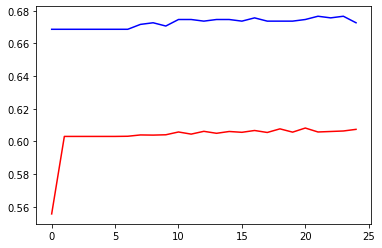

In [47]:
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')

In [48]:
predictions = text_model.predict([X_test_data, X_test])

In [49]:
Y_test_data_decode = np.argmax(Y_test_data, axis=1)

In [50]:
predictions_decode = np.argmax(predictions, axis=1)

In [51]:
print(confusion_matrix(Y_test_data_decode, predictions_decode))

[[ 14  97   0   0   0   0   0]
 [ 10 660   0   0   0   0   0]
 [  0  11   0   0   0   0   0]
 [ 15  97   0   0   0   0   0]
 [  2  15   0   0   0   0   0]
 [ 15  33   0   0   0   0   0]
 [  2  31   0   0   0   0   0]]


In [52]:
print(classification_report(Y_test_data_decode, predictions_decode))

              precision    recall  f1-score   support

           0       0.24      0.13      0.17       111
           1       0.70      0.99      0.82       670
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00       112
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        33

    accuracy                           0.67      1002
   macro avg       0.13      0.16      0.14      1002
weighted avg       0.49      0.67      0.57      1002



/Users/philgodley/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2. Do the same with the CNN on its own, again, saving the weights.

In [53]:
# Set filepath to save weights for text data into

image_weights_filepath = 'TF Keras Concat Weights Image.hdf5'

# Set up checkpoint to record best weights

checkpoint = ModelCheckpoint(image_weights_filepath, monitor='val_acc',
                            verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

In [54]:
# image_inputs = keras.Input(shape=(75,100,3))
# CNN Model for images

pre_trained_model= VGG16(input_shape=(75, 100, 3),
                        include_top = False,
                        weights = 'imagenet')

for layer in pre_trained_model.layers[:-1]:
    layer.trainable = False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0     

In [55]:
# Adjust the model to requirements...

outer_layer = pre_trained_model.get_layer('block5_pool')
outer_input = outer_layer.output

x_image = keras.layers.Flatten()(outer_input)
x_image = keras.layers.Dense(1000, activation='relu')(x_image)
x_image = keras.layers.Dense(64, activation='relu')(x_image)

x_image_output = keras.layers.Dense(7, activation='softmax')(x_image)

In [56]:
image_model = keras.models.Model(pre_trained_model.input, x_image_output)

image_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0   

In [57]:
# Compile

image_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [80]:
# Fit

image_history = image_model.fit(X_train_image, Y_train_data, 
    epochs=1, 
    batch_size=128,
    validation_data=(X_test_image, Y_test_data), callbacks=callbacks_list)

Train on 9932 samples, validate on 1002 samples
9856/9932 [============================>.] - ETA: 0s - loss: 0.9860 - acc: 0.6520
Epoch 00001: val_acc improved from 0.70958 to 0.72056, saving model to TF Keras Concat Weights Concat.hdf5
9932/9932 [==============================] - 135s 14ms/sample - loss: 0.9839 - acc: 0.6528 - val_loss: 0.8243 - val_acc: 0.7206


In [81]:
acc = image_history.history['acc']
val_acc = image_history.history['val_acc']
loss = image_history.history['loss']
val_loss = image_history.history['val_loss']
epochs = range(len(acc))

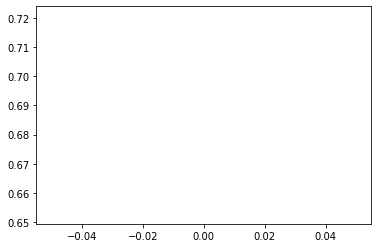

In [82]:
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')

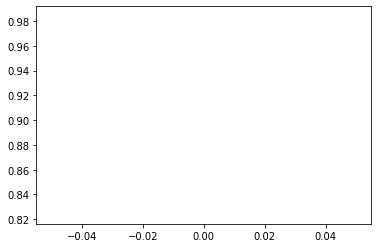

In [83]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')

In [84]:
predictions = image_model.predict(X_test_image)

In [85]:
Y_test_data_decode = np.argmax(Y_test_data, axis=1)

In [86]:
predictions_decode = np.argmax(predictions, axis=1)

In [87]:
print(confusion_matrix(Y_test_data_decode, predictions_decode))

[[ 24  76   0  10   0   1   0]
 [  2 658   2   7   0   0   1]
 [  1   6   3   1   0   0   0]
 [  5  82   1  23   1   0   0]
 [  0  14   0   1   1   1   0]
 [  7  28   3   2   0   4   4]
 [  6  13   0   3   0   2   9]]


In [88]:
print(classification_report(Y_test_data_decode, predictions_decode))

              precision    recall  f1-score   support

           0       0.53      0.22      0.31       111
           1       0.75      0.98      0.85       670
           2       0.33      0.27      0.30        11
           3       0.49      0.21      0.29       112
           4       0.50      0.06      0.11        17
           5       0.50      0.08      0.14        48
           6       0.64      0.27      0.38        33

    accuracy                           0.72      1002
   macro avg       0.54      0.30      0.34      1002
weighted avg       0.67      0.72      0.66      1002



### 3. Run the concatenated model, but this time, do not allow the tabular data nor the CNN weights to be trained. i.e. you can only update the weights on the final layer.


In [59]:
# Set filepath to save weights for text data into

concat_weights_filepath = 'TF Keras Concat Weights Concat.hdf5'

# Set up checkpoint to record best weights

checkpoint = ModelCheckpoint(concat_weights_filepath, monitor='val_acc',
                            verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

In [60]:
# Set up your concatenated model

concatenated = keras.layers.concatenate([x_text ,x_image], axis=1)

In [61]:
output = keras.layers.Dense(7, activation='softmax')(concatenated)

In [62]:
# Define your model

concat_model = keras.models.Model([text_model.input, image_model.input], output)

In [63]:
for layer in concat_model.layers[:-1]:
    layer.trainable = False

In [74]:
concat_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [75]:
concat_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 100, 3)] 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 75, 100, 64)  1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 75, 100, 64)  36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 37, 50, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [76]:
# Load weights
# concat_model.load_weights(['TF Keras Concat Weights Text.hdf5', 'TF Keras Concat Weights Image.hdf5'], by_name=True)

In [77]:
# Fit the model

concat_history = concat_model.fit(
    [X_train_data, X_train_image], Y_train_data, 
    epochs=10, 
    batch_size=128,
    validation_data=([X_test_data, X_test_image], Y_test_data), callbacks=callbacks_list)

Train on 9932 samples, validate on 1002 samples
Epoch 1/10
9856/9932 [============================>.] - ETA: 0s - loss: 1.0820 - acc: 0.6238
Epoch 00001: val_acc did not improve from 0.69261
9932/9932 [==============================] - 133s 13ms/sample - loss: 1.0810 - acc: 0.6242 - val_loss: 0.9147 - val_acc: 0.6916
Epoch 2/10
9856/9932 [============================>.] - ETA: 0s - loss: 1.0726 - acc: 0.6239
Epoch 00002: val_acc improved from 0.69261 to 0.69361, saving model to TF Keras Concat Weights Concat.hdf5
9932/9932 [==============================] - 131s 13ms/sample - loss: 1.0720 - acc: 0.6242 - val_loss: 0.9101 - val_acc: 0.6936
Epoch 3/10
9856/9932 [============================>.] - ETA: 0s - loss: 1.0674 - acc: 0.6260
Epoch 00003: val_acc improved from 0.69361 to 0.69461, saving model to TF Keras Concat Weights Concat.hdf5
9932/9932 [==============================] - 136s 14ms/sample - loss: 1.0674 - acc: 0.6263 - val_loss: 0.9052 - val_acc: 0.6946
Epoch 4/10
9856/9932 [===

In [91]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

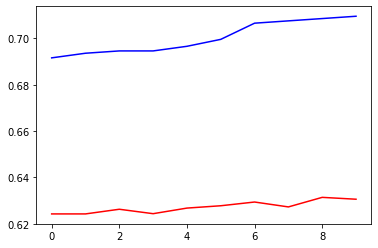

In [92]:
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')

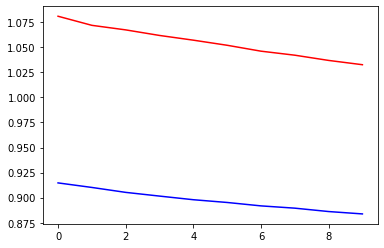

In [93]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')

In [94]:
predictions = concat_model.predict([X_test_data, X_test_image])

In [95]:
Y_test_data_decode = np.argmax(Y_test_data, axis=1)

In [96]:
predictions_decode = np.argmax(predictions, axis=1)

In [97]:
print(confusion_matrix(Y_test_data_decode, predictions_decode))

[[ 20  86   0   2   0   3   0]
 [  2 668   0   0   0   0   0]
 [  1   9   0   1   0   0   0]
 [  6  99   0   5   0   2   0]
 [  0  17   0   0   0   0   0]
 [ 10  27   0   3   0   7   1]
 [ 11  20   0   0   0   2   0]]


In [98]:
print(classification_report(Y_test_data_decode, predictions_decode))

              precision    recall  f1-score   support

           0       0.40      0.18      0.25       111
           1       0.72      1.00      0.84       670
           2       0.00      0.00      0.00        11
           3       0.45      0.04      0.08       112
           4       0.00      0.00      0.00        17
           5       0.50      0.15      0.23        48
           6       0.00      0.00      0.00        33

    accuracy                           0.70      1002
   macro avg       0.30      0.20      0.20      1002
weighted avg       0.60      0.70      0.61      1002



/Users/philgodley/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
